In [1]:
from preprocess.preprocess import *
import PARAMETERS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'DRIVE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu,get_pyramid_dataset,lanczos,False,5,True,True


### Resultado CV

F1-score 0.685426

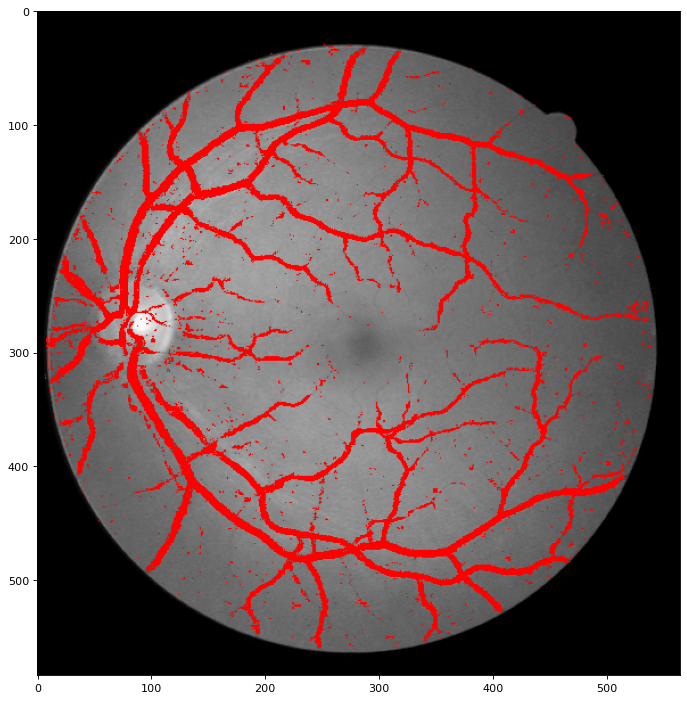

Accuracy score: 0.9292555186111174

F1 score: 0.7211952246541113

Confusion matrix:

     t/p      0     1 
        0 1141617 45928 
        1 50476 124686 
Sensivity: 0.7118324750802114
Specificity: 0.9613252550429668


(0.929, 0.721, 1141617, 45928, 50476, 124686)

In [2]:
from main import main
PARAMETERS.PLOT = True

main(lgb='Num', all_lbp=['riu', 'var'], plot_once=True, channels=(1, 2), recurrence=False)

In [3]:
import pickle
from os import listdir

PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
MASK_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/mask'
LABELS_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/1st_manual'

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:14]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:14]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

In [4]:
with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16497076349499857 - 3LBP/population.pkl', 'rb') as f:
    kernels = pickle.load(f)
    
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
n_kernels = 3
k_size = (3, 5, 7)

features = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES, MASKS, features)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features = pd.concat(features, ignore_index=True)
display(conv_features)

,0,1,2
0,24,0,182
1,26,0,176
2,31,0,168
3,38,0,157
4,39,0,159
...,...,...,...
3178294,0,96,17
3178295,0,101,19
3178296,0,97,24
3178297,0,94,30


In [5]:
import pandas as pd
import numpy as np

preprocess = Preprocess(height=608, width=576)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])
    
cv_folds

{0: (0, 681473),
 1: (681473, 1361653),
 2: (1361653, 2044115),
 3: (2044115, 2724019),
 4: (2724019, 3178299)}

In [6]:
from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def test_features(features, verbose=False):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        PARAMETERS.MODEL_NAME = f"_cv_feat_sel_{k}"
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(
            df_train_temp, y_train_temp.values.ravel(), lgb='Num', parent_path='../models')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}

In [7]:
from main import get_channel_features, get_labels
import pandas as pd

df_train, df_test = get_channel_features('../', lbp_version=['riu', 'var'], channels=(1, 2))
conv_features.index = df_train.index
y_train, y_test = get_labels('../')

In [8]:
display(df_train)

df_train = pd.concat([df_train, conv_features], axis=1)

features = {'x_train': df_train, 'x_test': None, 'y_train': y_train, 'y_test': None}

,green_Original,green_riu_1:1,green_riu_1:2,green_riu_1:4,green_riu_1:8,green_riu_2:1_1,green_riu_2:1_2,green_riu_2:1_3,green_riu_2:1_4,blue_Original,...,green_var_2:1_3,green_var_2:1_4,blue_var_1:1,blue_var_1:2,blue_var_1:4,blue_var_1:8,blue_var_2:1_1,blue_var_2:1_2,blue_var_2:1_3,blue_var_2:1_4
0,0.0,35.0,8.0,8.0,8.0,35.0,35.0,8.0,8.0,1.0,...,55.0,69.0,27.176735,1637.007165,1306.551069,1157.878241,10.0,13.0,3.0,1.0
1,0.0,27.0,8.0,8.0,8.0,35.0,27.0,8.0,8.0,1.0,...,86.0,102.0,46.207535,1637.007165,1306.551069,1157.878241,13.0,14.0,3.0,9.0
2,0.0,8.0,8.0,8.0,8.0,35.0,27.0,16.0,8.0,0.0,...,138.0,154.0,70.187899,1788.711292,1320.562749,1157.878241,11.0,9.0,7.0,6.0
3,0.0,4.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,...,166.0,180.0,72.674270,1788.711292,1320.562749,1157.878241,6.0,3.0,11.0,27.0
4,0.0,8.0,8.0,8.0,8.0,8.0,8.0,4.0,8.0,0.0,...,196.0,214.0,62.853232,1848.534023,1320.562749,1157.878241,2.0,2.0,37.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,0.0,16.0,4.0,27.0,8.0,8.0,8.0,8.0,8.0,0.0,...,84.0,75.0,19.041829,295.481488,507.872500,985.396140,0.0,1.0,0.0,0.0
226538,0.0,8.0,4.0,27.0,8.0,16.0,8.0,35.0,35.0,0.0,...,69.0,66.0,18.681217,295.481488,507.872500,985.396140,1.0,2.0,0.0,0.0
226539,0.0,8.0,8.0,16.0,8.0,8.0,8.0,8.0,16.0,0.0,...,61.0,51.0,13.971574,228.299942,469.304608,985.396140,0.0,0.0,0.0,0.0
226540,0.0,16.0,8.0,16.0,8.0,8.0,8.0,16.0,8.0,0.0,...,41.0,28.0,9.588321,228.299942,469.304608,985.396140,0.0,0.0,0.0,0.0


In [9]:
test_features(features, verbose=True)

Accuracy score: 0.9386593452711993

F1 score: 0.719746845626785

Confusion matrix:

     t/p      0     1 
        0 585993 19316 
        1 22486 53678 
Sensivity: 0.7047686571083451
Specificity: 0.9680890256051041
-------------------------------------
Accuracy score: 0.9255946955217736

F1 score: 0.6821262349963256

Confusion matrix:

     t/p      0     1 
        0 575270  7535 
        1 43074 54301 
Sensivity: 0.5576482670089858
Specificity: 0.9870711472962654
-------------------------------------
Accuracy score: 0.9386720432786001

F1 score: 0.7504531361793465

Confusion matrix:

     t/p      0     1 
        0 577675 15769 
        1 26085 62933 
Sensivity: 0.7069693769799367
Specificity: 0.9734279898356037
-------------------------------------
Accuracy score: 0.9408107615192733

F1 score: 0.6983260744083539

Confusion matrix:

     t/p      0     1 
        0 593083 14091 
        1 26152 46578 
Sensivity: 0.6404234841193456
Specificity: 0.976792484526676
--------------------

{'acc': 0.9293509616161881, 'f1': 0.6994928972157155}

,0,1,2
0,7,0,115
1,8,0,112
2,8,0,111
3,6,0,118
4,7,0,122
...,...,...,...
226969,0,53,29
226970,0,54,27
226971,0,52,31
226972,0,54,28


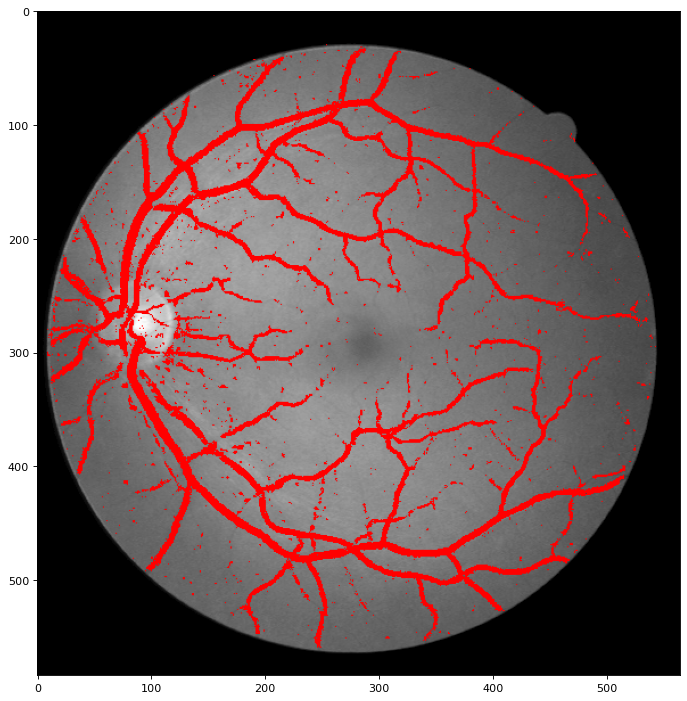

Accuracy score: 0.931599382699289

F1 score: 0.7334008340340822

Confusion matrix:

     t/p      0     1 
        0 1141289 46256 
        1 46954 128208 
Sensivity: 0.7319395759354198
Specificity: 0.9610490549831796


(0.932, 0.733, 1141289, 46256, 46954, 128208)

In [10]:
def load_images_test():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][14:]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks_test():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][14:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images_test()
MASKS_test = load_masks_test()

features_test = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features_test = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES_test, MASKS_test, features_test)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features_test = pd.concat(features_test, ignore_index=True)
conv_features_test.index = df_test.index
display(conv_features_test)

extra_features = {'train': conv_features, 'test': conv_features_test}
main(lgb='Num', all_lbp=['riu', 'var'], extra_features=extra_features, plot_once=True, channels=(1, 2), recurrence=False)

### Clasificador utilizando únicamente la intensidad de gris en el canal verde

In [11]:
green_channel_train = pd.DataFrame(
    [item for sublist in [img[mask].ravel().tolist() for img, mask in zip(IMAGES, MASKS)] for item in sublist]
)
green_channel_train.index = y_train.index
green_channel_test = pd.DataFrame(
    [item for sublist in [img[mask].ravel().tolist() for img, mask in zip(IMAGES_test, MASKS_test)] for item in sublist]
)
green_channel_test.index = y_test.index

In [12]:
display(green_channel_train)

,0
0,4
1,3
2,3
3,10
4,9
...,...
226537,6
226538,3
226539,9
226540,4


In [13]:
features = {
    'x_train': green_channel_train, 'x_test': green_channel_test,
    'y_train': y_train, 'y_test': y_test
}

### Resultados convolución

Green channel


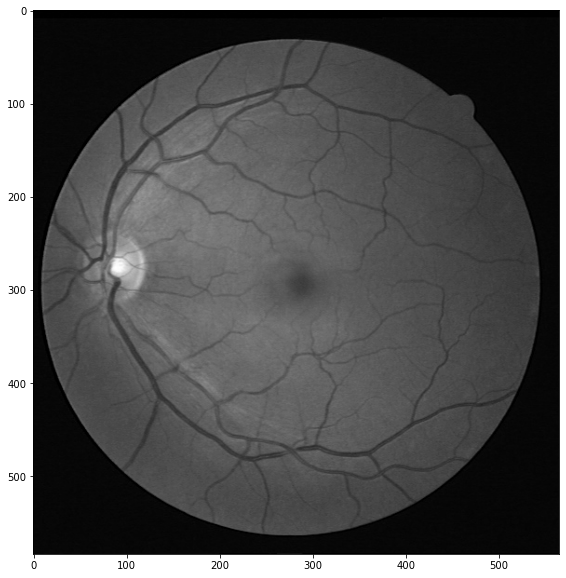


 Convolved images


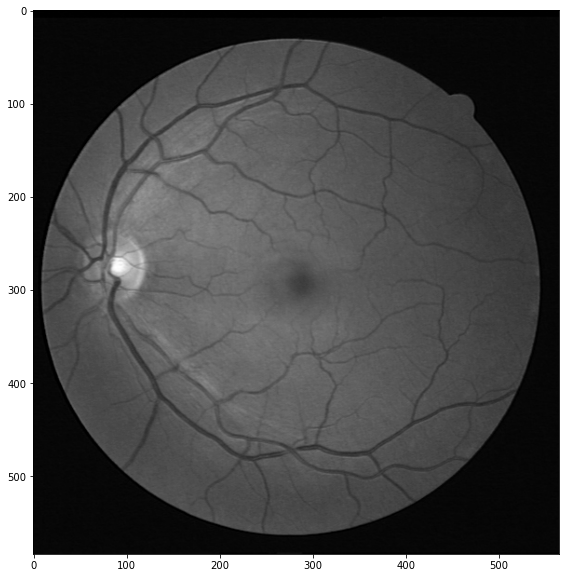

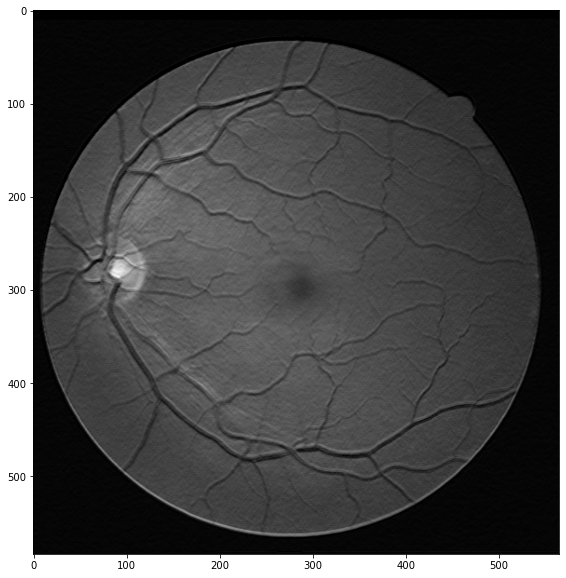

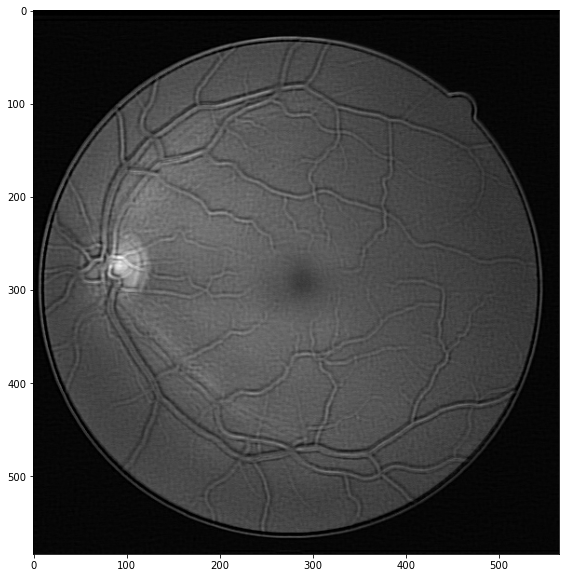

In [14]:
import numpy as np
import pickle


#kernel_list = [population[np.argmax(fitness), k:k+9] for k in range(0, len(individual), 9)]

kernel_list = []
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    kernel_list += [
        individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks))
        for i in range(n_kernels // len(k_size))
    ]
    count += k_len * (n_kernels // len(k_size))


PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
path = PATH + '/35_training.tif'

from os import listdir
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from preprocess.preprocess import Preprocess

img = np.asarray(Image.open(path).convert('RGB'))[:, :, 1]
img_convolved = [cv2.filter2D(img, -1, k) for k in kernel_list]
import matplotlib.pyplot as plt
from PIL import Image
from convolution.fitness import IMAGES

im_list = [Image.fromarray(np.uint8(im)) for im in img_convolved]

print('Green channel')
plt.figure(figsize=(18, 10))
plt.imshow(img, cmap='gray')
plt.show()

print('\n Convolved images')
for im in im_list:
    plt.figure(figsize=(18, 10))
    plt.imshow(im, cmap='gray')
    plt.show()

## Aplicación del operador LBP a las imágenes convolucionadas

In [15]:
kernel_list

[array([[ 0.0400595 ,  0.03424368, -0.31129904],
        [ 0.08848466,  0.35070668,  0.34534155],
        [-0.0087628 ,  0.49044494, -0.04131439]]),
 array([[ 0.12325464, -0.09458872,  0.11614812,  0.19606728,  0.26940052],
        [ 0.03577557,  0.15821297,  0.84450553,  0.06292131, -0.26329943],
        [-0.1108746 ,  0.12271347, -0.26029144,  0.08965754,  0.06109624],
        [-0.01453992,  0.0831522 ,  0.07415056,  0.00212196,  0.21240593],
        [ 0.07287607,  0.0526256 , -0.74574875, -0.20812492, -0.06826703]]),
 array([[ 9.44711804e-02,  2.04990067e-01, -1.68279755e-02,
          3.14988962e-02,  5.09887027e-02,  3.12456845e-01,
         -2.75998165e-02],
        [ 1.96005288e-01,  2.50644439e-02, -1.05734913e-02,
         -7.94174635e-02,  9.59311958e-02, -1.56118685e-01,
          3.81914131e-01],
        [-4.70486338e-04,  4.57579180e-02, -1.68892803e-03,
         -9.78493470e-01,  4.53861521e-02, -1.69131558e-01,
          1.39521670e-03],
        [ 1.61520063e-01, -2.1948

In [16]:
def convolution_features(kernel):
    from create_db import main
    PARAMETERS.METHOD = 'get_pyramid_dataset'
    PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
    PARAMETERS.BALANCE = False
    PARAMETERS.N_SCALES = 5
    PARAMETERS.GRAY_INTENSITY = True
    PARAMETERS.X2SCALE = True
    PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
    PARAMETERS.PLOT = False
    PARAMETERS.CONVOLUTION = kernel
    PARAMETERS.CONV_PATH = PARAMETERS.update_convolution_path(PARAMETERS)
    PARAMETERS.DATASET = 'DRIVE'
    PARAMETERS.CHANNEL = 1
    main()
    return f"../DB/{PARAMETERS.DATASET}/extra_features/convolution/{PARAMETERS.CONV_PATH}"
    
def generate_features(kernel_list):
    return Parallel(n_jobs=3)(delayed(convolution_features)(kernel) for kernel in kernel_list)

paths = generate_features(kernel_list)

In [17]:
def get_features(paths):
    for i, path in enumerate(paths):
        train_path = list(Path(path).glob('train_train*'))[0]
        test_path = list(Path(path).glob('train_test*'))[0]
        if i == 0:
            df_train_convolutions = pd.read_pickle(train_path, compression='gzip')
            df_train_convolutions.drop(['label'], axis=1, inplace=True)
            df_train_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_train_convolutions.columns]
            df_test_convolutions = pd.read_pickle(test_path, compression='gzip')
            df_test_convolutions.drop(['label'], axis=1, inplace=True)
            df_test_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_test_convolutions.columns]
        else:
            df_temp = pd.read_pickle(train_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_train_convolutions = pd.concat([df_train_convolutions, df_temp], axis=1)
            df_temp = pd.read_pickle(test_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_test_convolutions = pd.concat([df_test_convolutions, df_temp], axis=1)
    return df_train_convolutions, df_test_convolutions

df_train_convolutions, df_test_convolutions = get_features(paths)

In [18]:
display(df_train_convolutions)

,Original_d2200fd4deefd8a72af53531bc2c2022bda1aec147cb6d56ac36eb022c02a4e4,1:1_d2200fd4deefd8a72af53531bc2c2022bda1aec147cb6d56ac36eb022c02a4e4,1:2_d2200fd4deefd8a72af53531bc2c2022bda1aec147cb6d56ac36eb022c02a4e4,1:4_d2200fd4deefd8a72af53531bc2c2022bda1aec147cb6d56ac36eb022c02a4e4,1:8_d2200fd4deefd8a72af53531bc2c2022bda1aec147cb6d56ac36eb022c02a4e4,2:1_1_d2200fd4deefd8a72af53531bc2c2022bda1aec147cb6d56ac36eb022c02a4e4,2:1_2_d2200fd4deefd8a72af53531bc2c2022bda1aec147cb6d56ac36eb022c02a4e4,2:1_3_d2200fd4deefd8a72af53531bc2c2022bda1aec147cb6d56ac36eb022c02a4e4,2:1_4_d2200fd4deefd8a72af53531bc2c2022bda1aec147cb6d56ac36eb022c02a4e4,Original_c89b38d18cfb0209e92ff4d63c6a10615c732064c74ab9dc66bfac66ddeada34,...,2:1_4_c89b38d18cfb0209e92ff4d63c6a10615c732064c74ab9dc66bfac66ddeada34,Original_1b6053817fcc727c144994166c5e228360da620d576ef544071b448eeccc67cc,1:1_1b6053817fcc727c144994166c5e228360da620d576ef544071b448eeccc67cc,1:2_1b6053817fcc727c144994166c5e228360da620d576ef544071b448eeccc67cc,1:4_1b6053817fcc727c144994166c5e228360da620d576ef544071b448eeccc67cc,1:8_1b6053817fcc727c144994166c5e228360da620d576ef544071b448eeccc67cc,2:1_1_1b6053817fcc727c144994166c5e228360da620d576ef544071b448eeccc67cc,2:1_2_1b6053817fcc727c144994166c5e228360da620d576ef544071b448eeccc67cc,2:1_3_1b6053817fcc727c144994166c5e228360da620d576ef544071b448eeccc67cc,2:1_4_1b6053817fcc727c144994166c5e228360da620d576ef544071b448eeccc67cc
0,1.0,8.0,1.0,0.0,34.0,8.0,8.0,8.0,8.0,0.0,...,35.0,-3.0,26.0,0.0,9.0,8.0,1.0,1.0,34.0,34.0
1,1.0,8.0,1.0,0.0,34.0,16.0,16.0,8.0,8.0,0.0,...,35.0,-3.0,34.0,0.0,9.0,8.0,1.0,1.0,34.0,27.0
2,1.0,8.0,1.0,35.0,34.0,16.0,8.0,8.0,8.0,0.0,...,35.0,-4.0,34.0,9.0,6.0,8.0,1.0,0.0,4.0,8.0
3,2.0,6.0,1.0,35.0,34.0,8.0,4.0,8.0,8.0,0.0,...,35.0,-4.0,35.0,9.0,6.0,8.0,9.0,9.0,8.0,16.0
4,2.0,5.0,1.0,35.0,34.0,8.0,8.0,8.0,8.0,0.0,...,35.0,-4.0,34.0,9.0,6.0,8.0,1.0,1.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,0.0,35.0,35.0,35.0,8.0,8.0,8.0,35.0,35.0,4.0,...,8.0,1.0,8.0,16.0,8.0,4.0,8.0,8.0,1.0,0.0
226538,0.0,35.0,35.0,35.0,8.0,35.0,8.0,35.0,35.0,4.0,...,16.0,1.0,8.0,16.0,8.0,4.0,16.0,16.0,1.0,1.0
226539,0.0,35.0,35.0,35.0,8.0,8.0,4.0,35.0,35.0,4.0,...,8.0,1.0,8.0,8.0,8.0,4.0,16.0,8.0,9.0,9.0
226540,0.0,35.0,35.0,35.0,8.0,8.0,8.0,35.0,35.0,4.0,...,8.0,1.0,8.0,8.0,8.0,4.0,8.0,8.0,1.0,1.0


In [19]:
ext_features = {'train': df_train_convolutions, 'test': df_test_convolutions}

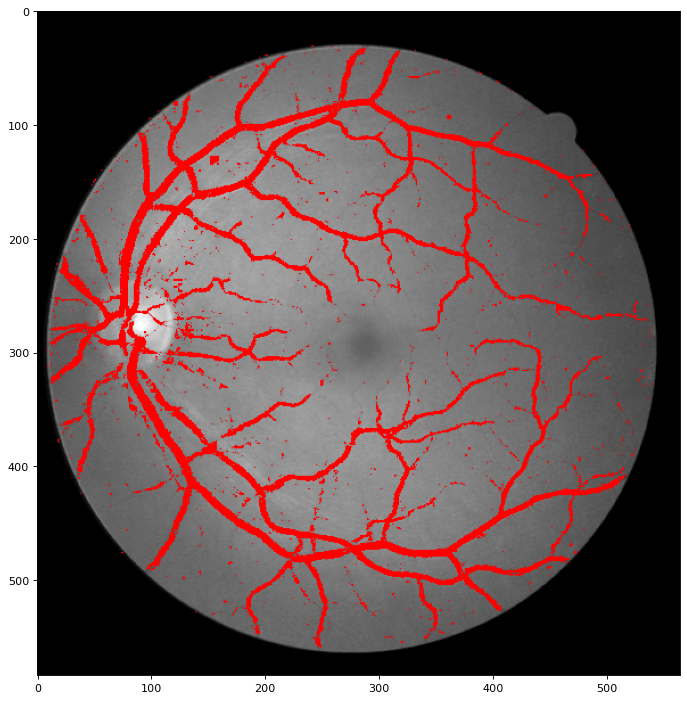

Accuracy score: 0.9344371167096082

F1 score: 0.739302086038511

Confusion matrix:

     t/p      0     1 
        0 1146682 40863 
        1 48480 126682 
Sensivity: 0.723227640698325
Specificity: 0.9655903565759614


(0.934, 0.739, 1146682, 40863, 48480, 126682)

In [20]:
main(lgb='Num', all_lbp=['riu', 'var'], extra_features=ext_features, plot_once=True, channels=(1, 2), recurrence=False)

In [21]:
df_train, df_test = get_channel_features('../', lbp_version=['riu', 'var'], channels=(1, 2))
ext_features['train'].index = df_train.index
df_train = pd.concat([df_train, ext_features['train']], axis=1)
test_features(features = {'x_train': df_train, 'x_test': None, 'y_train': y_train, 'y_test': None}, verbose=True)

Accuracy score: 0.9351170185759378

F1 score: 0.7082068473985692

Confusion matrix:

     t/p      0     1 
        0 583599 21710 
        1 22506 53658 
Sensivity: 0.7045060658578857
Specificity: 0.9641340208059025
-------------------------------------
Accuracy score: 0.9213972771913317

F1 score: 0.6689904530764373

Confusion matrix:

     t/p      0     1 
        0 572689 10116 
        1 43348 54027 
Sensivity: 0.554834403080873
Specificity: 0.9826425648372955
-------------------------------------
Accuracy score: 0.9363187987023454

F1 score: 0.7337662337662338

Confusion matrix:

     t/p      0     1 
        0 579112 14332 
        1 29128 59890 
Sensivity: 0.6727852793816981
Specificity: 0.9758494483051475
-------------------------------------
Accuracy score: 0.9402871581870381

F1 score: 0.7004493370618226

Confusion matrix:

     t/p      0     1 
        0 591838 15336 
        1 25263 47467 
Sensivity: 0.6526467757459096
Specificity: 0.9747420014691011
-------------------

{'acc': 0.9276150692862835, 'f1': 0.6928790073959654}

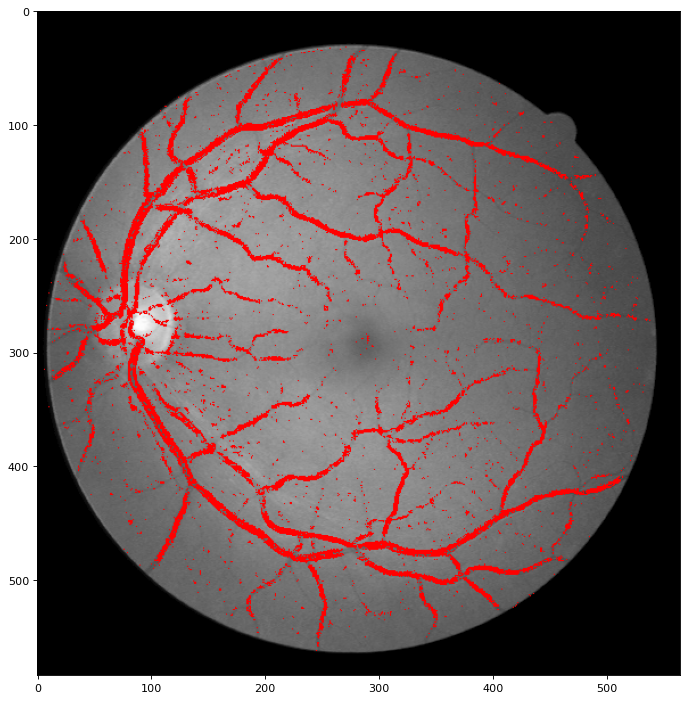

Accuracy score: 0.9169623404003943

F1 score: 0.6196130107975097

Confusion matrix:

     t/p      0     1 
        0 1157391 30154 
        1 83002 92160 
Sensivity: 0.5261415147120951
Specificity: 0.9746081201133431


(0.917, 0.62, 1157391, 30154, 83002, 92160)

In [23]:
ext_features = {'x_train': df_train_convolutions, 'x_test': df_test_convolutions, 'y_train': y_train, 'y_test': y_test}
main(lgb='Num', features=ext_features, plot_once=True, recurrence=False)